# Naive QG Implementation

In [3]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb
from jaxsw._src.models.qg import qg_r as qg

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Equations

$$

$$

$$
\begin{aligned}
\partial_t q &= - \det\boldsymbol{J}(\psi,q) - \beta\partial_x\psi \\
q &= \nabla^2 \psi - \frac{1}{L_R^2}\psi \\
\psi &= \frac{f_0}{g}\eta \\
u &= -\partial_y\psi \\
v &= \partial_x\psi \\
f &= 2\Omega\sin\theta_0 + \frac{1}{R}2\Omega\cos\theta_0 y \\
f_0 &= \mathcal{E}[f] \\
L_R &= \frac{c_1}{f_0}
\end{aligned}
$$

where:
* $f_0=2\Omega\sin\theta_0$ is the Coriolis parameter at mean latitude $\bar{\theta}$
* $\beta=\frac{1}{R}2\Omega\cos\theta_0$ is the $\beta$-plane approximation at mean latitude
* $L_R$ is the Rossby deformation radius
* $\Omega$ is the angular frequency of rotation

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

* f_0, beta are constants
* otherwise we cannot use the DST function :)

## Read input SSH

In [4]:
ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60_GULFSTREAM_degraded.nc')
ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc', decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))
# ds = ds.coarsen(lon=3,lat=3).mean()
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh      (time, lat, lon) float64 ...

In [71]:
lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values.T


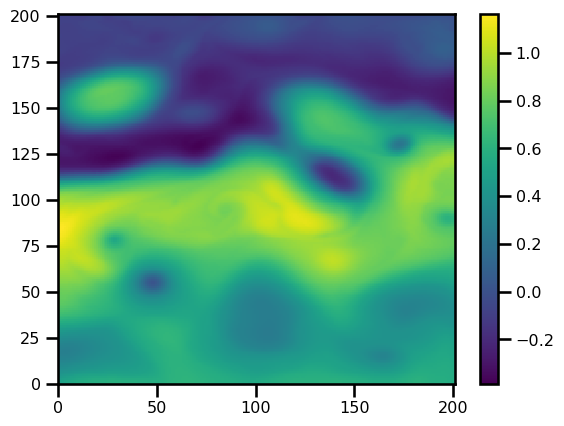

In [73]:
plt.figure()
plt.pcolormesh(ssh.T)
plt.colorbar()

In [7]:
def min_arrays(*args):
    arrays = [item for item in args]
    arrays = list(map(lambda x: x.min(), arrays))
    return np.min(np.stack([*arrays],axis=0))

def max_arrays(*args):
    arrays = [item for item in args]
    arrays = list(map(lambda x: x.max(), arrays))
    return np.max(np.stack([*arrays],axis=0))


## Naive Implementation

```python
# ssh -> pv
q = ssh_to_pv(ssh, lat, lon)
# pv -> ssh
h = pv_to_ssh(h, lat, lon)
```


$$
f_0 = 2\Omega\sin(\text{lat}\frac{\pi}{180})
$$

In [74]:
f0 = qg.coriolis_param(lat)

$$
\text{lat(m)} = 
$$

$$
d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}
$$

In [75]:
# from metpy.calc import lat_lon_grid_deltas
# out = lat_lon_grid_deltas(lon, lat)

We look at the [wiki page](https://en.wikipedia.org/wiki/Geographical_distance#Spherical_Earth_projected_to_a_plane) for the spherical Earth projected to a plane. Given some latitude, longitude pairs, $(\phi_1,\lambda_1), (\phi_2,\lambda_2)$, we can calculate the distance between them:

$$
\begin{aligned}
\Delta\phi &= \phi_2 - \phi_1 \\
\Delta\lambda &= \lambda_2 - \lambda_1
\end{aligned}
$$

We can also calculate the "mean" latitude

$$
\phi_m = \frac{\phi_1 + \phi_2}{2}
$$

Now we can calculate the distance between any set of points via the following formula:

$$
d = R \sqrt{(\Delta \phi)^2 + (cos(\phi_m)\Delta\lambda)^2}
$$

where $R$ is the radius of the Earth (6371200.0).


In [76]:
dx, dy, f = qg.lat_lon_deltas(lon, lat)

f0 = jnp.mean(f)

# Constants 
# f0 = 1e-5 # Coriolis frequency
c1 = 25_000 # First baroclinic phase speed

### SSH to Q

```python
def sshtoq(self, x):        
    ssh_tensor,lon_input,lat_input = x
    dx,dy,f0 = self.gridvar([lon_input,lat_input])
    laplaciansshx = F.conv2d(ssh_tensor, self.laplacian_x, padding=0)[:,:,2:-3,1:-2]*((9.81/(f0*(dx**2)))[:,:,2:-3,2:-3])
    laplaciansshy = F.conv2d(ssh_tensor, self.laplacian_y, padding=0)[:,:,1:-2,2:-3]*((9.81/(f0*(dy**2)))[:,:,2:-3,2:-3])
    zp = nn.ZeroPad2d((2, 3, 2, 3))
    return (-9.81*f0/(1.5**2))*ssh_tensor+ zp(laplaciansshx)+ zp(laplaciansshy)
```


$$
\psi = \frac{g}{f}\eta
$$


In [77]:
qg.ssh_to_streamfn??

Signature: qg.ssh_to_streamfn(ssh: jax.Array, f0: jax.Array, g=9.80665) -> jax.Array
Docstring: <no docstring>
Source:   
def ssh_to_streamfn(ssh: Array, f0: Array, g=GRAVITY) -> Array:
    return (g / f0) * ssh
File:      ~/code_projects/jaxsw/jaxsw/_src/models/qg/qg_r.py
Type:      function

In [78]:
psi = qg.ssh_to_streamfn(ssh, f0)

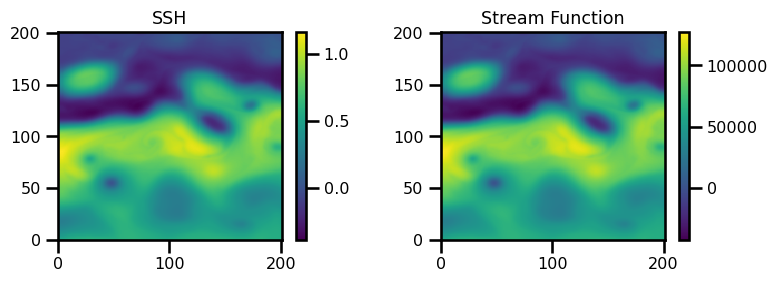

In [80]:
fig, ax = plt.subplots(ncols=2, figsize=(8,3))
pts = ax[0].pcolormesh(ssh.T)
ax[0].set_title("SSH")
plt.colorbar(pts)
pts = ax[1].pcolormesh(psi.T)
ax[1].set_title(r"Stream Function")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

### Potential Vorticity

$$
q = \nabla^2\psi - \frac{1}{L_R^2}\psi
$$

In [81]:
qg.laplacian_2d??

Signature: qg.laplacian_2d(array: jax.Array, dx: jax.Array, dy: jax.Array) -> jax.Array
Docstring: <no docstring>
Source:   
def laplacian_2d(array: Array, dx: Array, dy: Array) -> Array:
    lap_kernel_x = jnp.array([[1., -2., 1.]])
    lap_kernel_y = rearrange(lap_kernel_x, "1 K -> K 1")
    d2f_dx2 = jnp.pad(array, pad_width=((0,0),(1,1)), mode="constant")
    d2f_dx2 = jsp.signal.convolve(d2f_dx2, lap_kernel_x, mode="valid") / dx**2
    
    d2f_dy2 = jnp.pad(array, pad_width=((1,1),(0,0)), mode="constant") 
    d2f_dy2 = jsp.signal.convolve(d2f_dy2, lap_kernel_y, mode="valid") / dy**2
    
    return d2f_dx2 + d2f_dy2
File:      ~/code_projects/jaxsw/jaxsw/_src/models/qg/qg_r.py
Type:      function

In [45]:
def laplacian_bruno(psi, dx, dy):
    
    dx = jnp.mean(jnp.asarray([jnp.mean(dx), jnp.mean(dy)]))
    
    omega = (psi[...,2:,1:-1] + psi[...,:-2,1:-1] + psi[...,1:-1,2:] + psi[...,1:-1,:-2] - 4*psi[...,1:-1,1:-1])/(dx*dy)**2
    
    return omega

In [47]:
# psi_lap_b = laplacian_bruno(psi, dx, dx)

In [48]:
# psi_lap = 

In [49]:

# fig, ax = plt.subplots()

# ax.imshow(psi_lap, cmap=plt.cm.coolwarm)


In [82]:
# psi_lap = qg.laplacian_2d(psi, dx, dy)
# dx = jnp.mean(jnp.asarray([jnp.mean(dx), jnp.mean(dy)]))
psi_lap = fdx.laplacian(psi, step_size=(dx,dy), accuracy=1, method="central")

q = qg.streamfn_to_pvort(psi, dx, dy, c1)

In [83]:
qg.streamfn_to_pvort??

Signature:
qg.streamfn_to_pvort(
    psi: jax.Array,
    dx: jax.Array,
    dy: jax.Array,
    c1: float = 1.5,
    accuracy: int = 1,
) -> jax.Array
Docstring: <no docstring>
Source:   
def streamfn_to_pvort(psi: Array, dx: Array, dy: Array, c1: float=1.5, accuracy: int=1) -> Array:
    return fdx.laplacian(psi, step_size=(dx,dy), accuracy=accuracy) - (1./c1**2) * psi
File:      ~/code_projects/jaxsw/jaxsw/_src/models/qg/qg_r.py
Type:      function

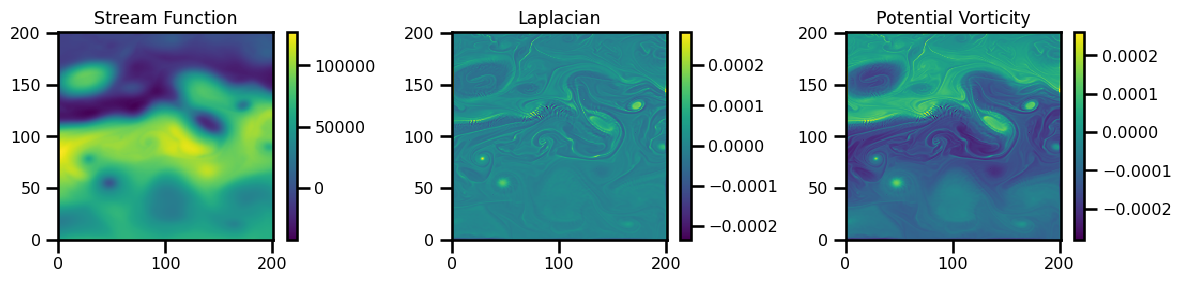

In [84]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3))
pts = ax[0].pcolormesh(psi.T)
ax[0].set_title("Stream Function")
plt.colorbar(pts)
pts = ax[1].pcolormesh(psi_lap.T)
ax[1].set_title(r"Laplacian")
plt.colorbar(pts)
pts = ax[2].pcolormesh(q.T)
ax[2].set_title(r"Potential Vorticity")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

### Geostrophic Velocities

```python
def dynqhardcoded(self, x):
    gradient_x = torch.cuda.DoubleTensor([[-0.25, -0.25], [0, 0], [0.25, 0.25]]).view([1, 1, 3, 2])
    gradient_y = torch.transpose(gradient_x,2,3)
    q_tensor,ssh_tensor,lon_input,lat_input = x
    dx,dy,f0 = self.gridvar([lon_input,lat_input])
    zp1 = nn.ZeroPad2d((1,1,1,0))
    zp2 = nn.ZeroPad2d((1,0,1,1))
    vvv_QG = zp1(F.conv2d(ssh_tensor,self.gradient_y,padding=0))
    uuu_QG = zp2(F.conv2d(ssh_tensor,self.gradient_x,padding=0))
    if self.qg:
        v = 9.81*vvv_QG/(f0*dx)
        u = -9.81*uuu_QG/(f0*dy)
    else:
        v # put your neural net
        u # put your neural net
```

In [64]:
qg.sobel_diff_x??

Signature: qg.sobel_diff_x(u: jax.Array, dx: jax.Array) -> jax.Array
Docstring: <no docstring>
Source:   
def sobel_diff_x(u: Array, dx: Array) -> Array:
    kernel = jnp.asarray([[-0.25,-0.25],[0,0],[0.25,0.25]])
    u = jnp.pad(u, pad_width=((1,1),(1,0)), mode="constant")
    out = jsp.signal.convolve(u, kernel, mode="valid")
    return out / dx
File:      ~/code_projects/jaxsw/jaxsw/_src/models/qg/qg_r.py
Type:      function

$$
\begin{aligned}
u &= - \partial_y\psi \\
v &= \partial_x\psi
\end{aligned}
$$

In [63]:
qg.streamfn_to_velocity??

Signature: qg.streamfn_to_velocity(psi, dx, dy)
Docstring: <no docstring>
Source:   
def streamfn_to_velocity(psi, dx, dy):
    
    v = sobel_diff_x(psi, dx)
    
    u = - sobel_diff_y(psi, dy)
    
    return u, v
File:      ~/code_projects/jaxsw/jaxsw/_src/models/qg/qg_r.py
Type:      function

In [65]:
u, v = qg.streamfn_to_velocity(psi, dx, dy)

In [85]:
u = - fdx.difference(psi, axis=1, step_size=dy, method="central")
v = fdx.difference(psi, axis=0, step_size=dx, method="central")

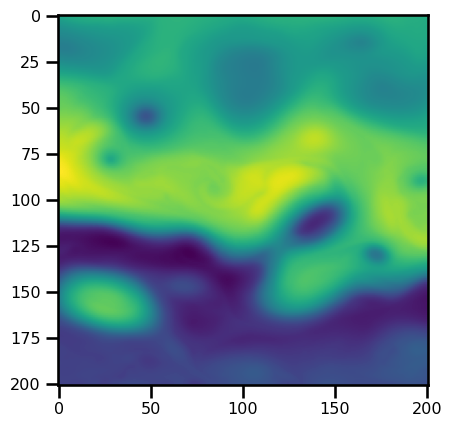

In [70]:
plt.imshow(psi)

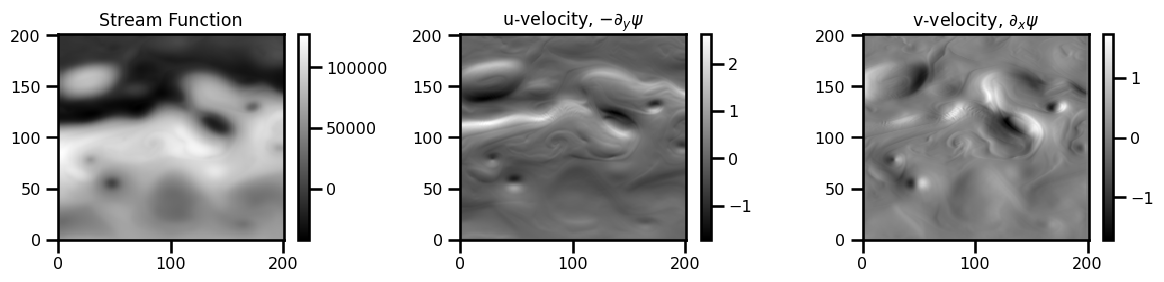

In [90]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3))
pts = ax[0].pcolormesh(psi.T, cmap="gray")
ax[0].set_title(r"Stream Function")
plt.colorbar(pts)
pts = ax[1].pcolormesh(u.T, cmap="gray")
ax[1].set_title(r"u-velocity, $-\partial_y\psi$")
plt.colorbar(pts)
pts = ax[2].pcolormesh(v.T, cmap="gray")
ax[2].set_title(r"v-velocity, $\partial_x\psi$")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

### Advection Term

We have the advection term which is the dot product between the geostrophic velocities and the gradient of the 

$$
\begin{aligned}
\begin{pmatrix}
u \\ v
\end{pmatrix} \cdot
\nabla q &= u \partial_x q + v \partial_y q
\end{aligned}
$$

if we plug in the actual $u,v$ terms, we get

$$
\begin{aligned}
\begin{pmatrix}
u \\ v
\end{pmatrix} \cdot
\nabla q &= - \partial_y\psi\partial_y q + \partial_x\psi\partial_y q \\
&= \partial_x\psi\partial_y q - \partial_y\psi\partial_y q
\end{aligned}
$$

Note, there is a famous common term that is used for a short hand notation. It's call the **determinant Jacobian** which is denoted as:

$$
\begin{aligned}
\det J(\psi, q) &= 
\frac{\partial\psi}{\partial_x}\frac{\partial q}{\partial_y} -
\frac{\partial\psi}{\partial_y}\frac{\partial q}{\partial_x} \\
&= 
\frac{\partial}{\partial_x}\left(\psi\frac{\partial q}{\partial_y}\right) -
\frac{\partial}{\partial_y}\left(\psi\frac{\partial q}{\partial_x}\right) \\
&= 
\frac{\partial}{\partial_y}\left(q\frac{\partial\psi}{\partial_x}\right) -
\frac{\partial}{\partial_x}\left(q\frac{\partial\psi}{\partial_y}\right)
\end{aligned}
$$

We can see that this is exactly equal to the above expression when we set $u=-\partial_y\psi$ and $v=\partial_x\psi$

$$
\begin{aligned}
\det J(\psi, q) &= 
v\frac{\partial q}{\partial_y} +
u \frac{\partial q}{\partial_x} \\
\end{aligned}
$$

### Upwind Scheme

This term is an advection equation. So we can use the upwind scheme to deal with this.

$$
\begin{aligned}
u\partial_x q := u^+ D_x^- q + u^- D_x^+ q \\
v\partial_y q := v^+ D_y^- q + v^- D_y^+ q \\
\end{aligned}
$$

where:
* $u^+,v^+ = u>0,v>0$
* $u^-,v^-=u<0,v<0$
* $D_x^-, D_y^-$ is a backward finite difference scheme
* $D_x^+, D_y^-$ is a forward finite difference scheme

Source: [Wikipedia](https://en.wikipedia.org/wiki/Upwind_scheme) | [Blog](https://en.wikipedia.org/wiki/Upwind_scheme)

#### Plus/Minus

$$
\begin{aligned}
\text{u-velocity}: && && u^+ &= \max(u,0) && && u^- = \min(u,0) \\
\text{v-velocity}: && && v^+ &= \max(v,0) && && v^- = \min(v,0)
\end{aligned}
$$

```python
gr1=torch.cuda.DoubleTensor([0.5, 0.5]).view([1, 1, 1, 2])
utmp = F.conv2d(u, gr1, padding=0)[:,:,2:-2,2:-1]
uplus = F.relu(utmp)
uminus = -1*F.relu(-1*utmp)

gr1=torch.cuda.DoubleTensor([0.5, 0.5]).view([1, 1, 2, 1])
gr2=torch.transpose(self.gr1,2,3)
vtmp = F.conv2d(v, gr2, padding=0)[:,:,2:-1,2:-2]
vplus = F.relu(vtmp)
vminus = -1*F.relu(-1*vtmp)
```

In [15]:
u_plus, u_minus = qg.u_plusminus(u)
v_plus, v_minus = qg.v_plusminus(v)
assert u_plus[2:-2,2:-1].shape == u_minus[2:-2,2:-1].shape 
assert v_plus[2:-1,2:-2].shape == v_minus[2:-1,2:-2].shape
u_plus.shape, v_plus.shape, u_minus.shape, v_minus.shape

((201, 201), (201, 201), (201, 201), (201, 201))

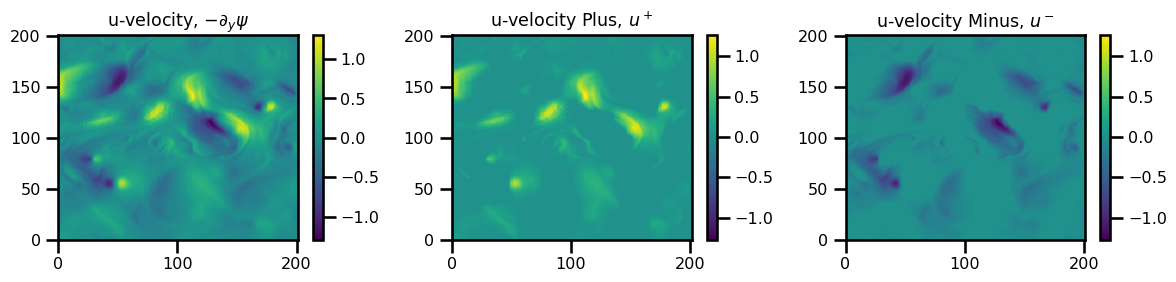

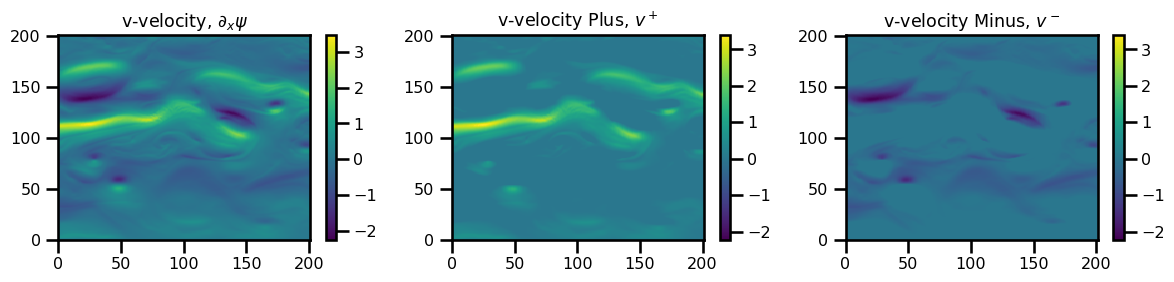

In [16]:
vmin = min_arrays(u_plus, u_minus)
vmax = max_arrays(u_plus, u_minus)

fig, ax = plt.subplots(ncols=3, figsize=(12,3))
pts = ax[0].pcolormesh(u)
ax[0].set_title(r"u-velocity, $-\partial_y\psi$")
plt.colorbar(pts)
pts = ax[1].pcolormesh(u_plus, vmin=vmin, vmax=vmax)
ax[1].set_title(r"u-velocity Plus, $u^+$")
plt.colorbar(pts)
pts = ax[2].pcolormesh(u_minus, vmin=vmin, vmax=vmax)
ax[2].set_title(r"u-velocity Minus, $u^-$")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

vmin = min_arrays(v_plus, v_minus)
vmax = max_arrays(v_plus, v_minus)

fig, ax = plt.subplots(ncols=3, figsize=(12,3))
pts = ax[0].pcolormesh(v)
ax[0].set_title(r"v-velocity, $\partial_x\psi$")
plt.colorbar(pts)
pts = ax[1].pcolormesh(v_plus, vmin=vmin, vmax=vmax)
ax[1].set_title(r"v-velocity Plus, $v^+$")
plt.colorbar(pts)
pts = ax[2].pcolormesh(v_minus, vmin=vmin, vmax=vmax)
ax[2].set_title(r"v-velocity Minus, $v^-$")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

#### PV Forward/Backward Schemes

$$
\begin{aligned}
D_x^-[q], D_y^-[q] \\
D_x^+[q], D_y^+[q] \\
\end{aligned}
$$


**I think these are staggered somehow...**

```python
qf1=torch.cuda.DoubleTensor([1/6, -1, 1/2, 1/3]).view([1, 1, 1, 4])
qf2=torch.transpose(qf1,2,3)
qf1bis=torch.cuda.DoubleTensor([1/3, 1/2, -1, 1/6]).view([1, 1, 1, 4])
qf2bis=torch.transpose(qf1bis, 2,3)
```

In [17]:
from jaxdf.conv import fd_coefficients_fornberg

In [18]:
accuracy = 3
order = 1
stagger = 0.0
points = np.arange(-accuracy // 2, accuracy//2 + 1)

if stagger > 0:
    points = (points + stagger)[:-1]
elif stagger < 0:
    points = (points + stagger)[1:]
    

stencil, nodes = fd_coefficients_fornberg(order, points, x0=0)
stencil, nodes, stencil.shape, nodes.shape

(array([ 0.16666667, -1.        ,  0.5       ,  0.33333333]),
 array([-2, -1,  0,  1]),
 (4,),
 (4,))

In [19]:
dq_dx_f = qg.forward_diff_x(q, dx)
dq_dy_f = qg.forward_diff_y(q, dy)
dq_dx_b = qg.backward_diff_x(q, dx)
dq_dy_b = qg.backward_diff_y(q, dy)

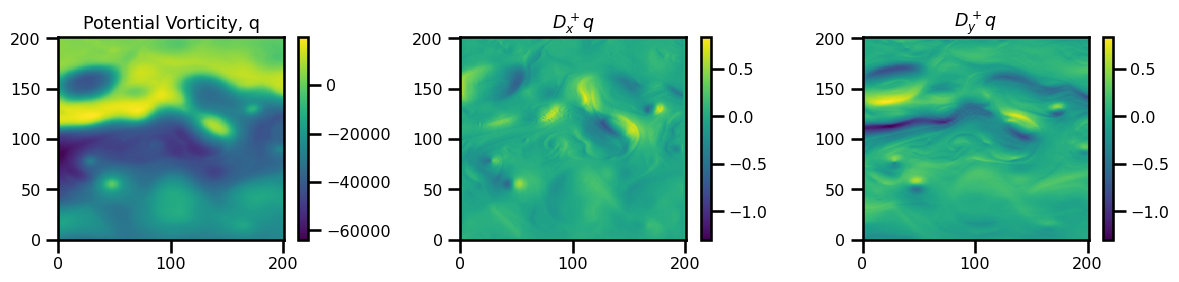

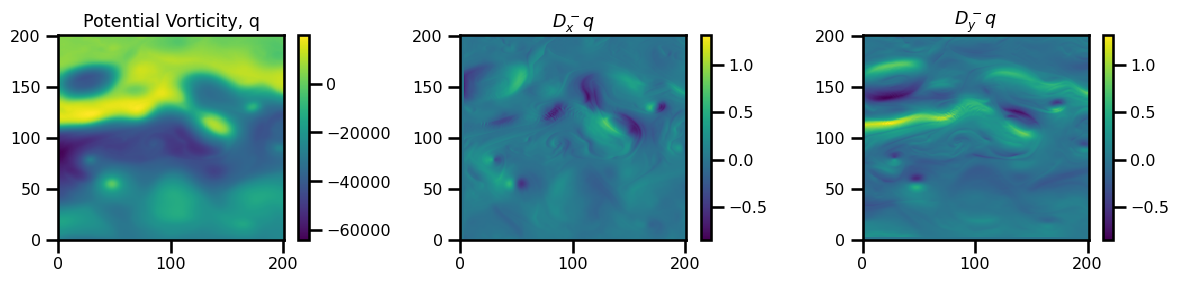

In [20]:
vmin = min_arrays(dq_dx_f, dq_dy_f)
vmax = max_arrays(dq_dx_f, dq_dy_f)

fig, ax = plt.subplots(ncols=3, figsize=(12,3))
pts = ax[0].pcolormesh(q)
ax[0].set_title(r"Potential Vorticity, q")
plt.colorbar(pts)
pts = ax[1].pcolormesh(dq_dx_f, vmin=vmin, vmax=vmax)
ax[1].set_title(r"$D_x^+ q$")
plt.colorbar(pts)
pts = ax[2].pcolormesh(dq_dy_f, vmin=vmin, vmax=vmax)
ax[2].set_title(r"$D_y^+ q$")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

vmin = min_arrays(dq_dx_b, dq_dy_b)
vmax = max_arrays(dq_dx_b, dq_dy_b)

fig, ax = plt.subplots(ncols=3, figsize=(12,3))
pts = ax[0].pcolormesh(q)
ax[0].set_title(r"Potential Vorticity, q")
plt.colorbar(pts)
pts = ax[1].pcolormesh(dq_dx_b, vmin=vmin, vmax=vmax)
ax[1].set_title(r"$D_x^- q$")
plt.colorbar(pts)
pts = ax[2].pcolormesh(dq_dy_b, vmin=vmin, vmax=vmax)
ax[2].set_title(r"$D_y^- q$")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

### Determinant Jacobian

**Test**

Define $\psi$:

$$
\psi(x,y) &= sin(x)sin(y)
$$

Do standard time integration WITHOUT doing the inversion! You can check the velocities, 

In [101]:
djac = qg.jacobian(psi, q, dx=dx, dy=dy, bc="dirichlet_face", pad=True)
djac.min(), djac.max()

(Array(-5.49551602e-08, dtype=float64), Array(8.37950146e-08, dtype=float64))

In [100]:
djac_test = qg.jacobian(psi, psi, dx=dx, dy=dy, bc="dirichlet_face", pad=True)
djac_test.min(), djac_test.max()

(Array(-5.93212246e-15, dtype=float64), Array(4.15279354e-15, dtype=float64))

In [99]:
qg.jacobian??

Signature:
qg.jacobian(
    p: jax.Array,
    q: jax.Array,
    dx: jax.Array,
    dy: jax.Array,
    bc: str = 'dirichlet',
    pad: bool = True,
) -> jax.Array
Docstring: <no docstring>
Source:   
def jacobian(
    p: Array,
    q: Array,
    dx: Array,
    dy: Array,
    bc: str = "dirichlet",
    pad: bool = True,
) -> Array:
    p = apply_bcs_2d(p, bc=bc, pad=pad)
    q = apply_bcs_2d(q, bc=bc, pad=pad)

    jac = (
        (q[2:, 1:-1] - q[:-2, 1:-1]) * (p[1:-1, 2:] - p[1:-1, :-2])
        + (q[1:-1, :-2] - q[1:-1, 2:]) * (p[2:, 1:-1] - p[:-2, 1:-1])
        + q[2:, 1:-1] * (p[2:, 2:] - p[2:, :-2])
        - q[:-2, 1:-1] * (p[:-2, 2:] - p[:-2, :-2])
        - q[1:-1, 2:] * (p[2:, 2:] - p[:-2, 2:])
        + q[1:-1, :-2] * (p[2:, :-2] - p[:-2, :-2])
        + p[1:-1, 2:] * (q[2:, 2:] - q[:-2, 2:])
        - p[1:-1, :-2] * (q[2:, :-2] - q[:-2, :-2])
        - p[2:, 1:-1] * (q[2:, 2:] - q[2:, :-2])
        + p[:-2, 1:-1] * (q[:-2, 2:] - q[:-2, :-2])
    )

    return jac / (12.0 * d

In [97]:
djac.shape, psi.shape, q.shape

((201, 201), (201, 201), (201, 201))

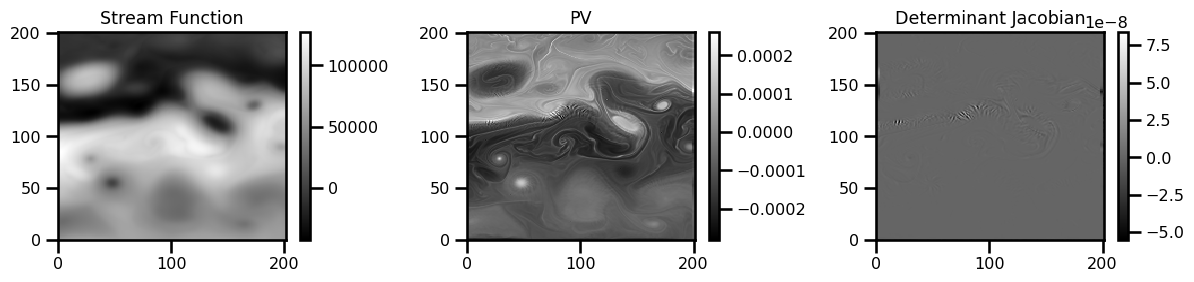

In [98]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3))
pts = ax[0].pcolormesh(psi.T, cmap="gray")
ax[0].set_title(r"Stream Function")
plt.colorbar(pts)
pts = ax[1].pcolormesh(q.T, cmap="gray")
ax[1].set_title(r"PV")
plt.colorbar(pts)
pts = ax[2].pcolormesh(djac.T, cmap="gray")
ax[2].set_title(r"Determinant Jacobian")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

### Beta Term

$$
\beta \psi_y = \beta v
$$

### All Terms

In [21]:
t1 = u_plus * dq_dx_b + u_minus * dq_dx_f
t2 = v_plus * dq_dy_b + v_minus * dq_dy_f
t3 = qg.beta_cdiff(f0, dy) * qg.diff_y(v)

out = t1 + t2 + t3

out = out.at[:2,:].set(0.0)
out = out.at[-3:,:].set(0.0)
out = out.at[:,:2].set(0.0)
out = out.at[:,-3:].set(0.0)

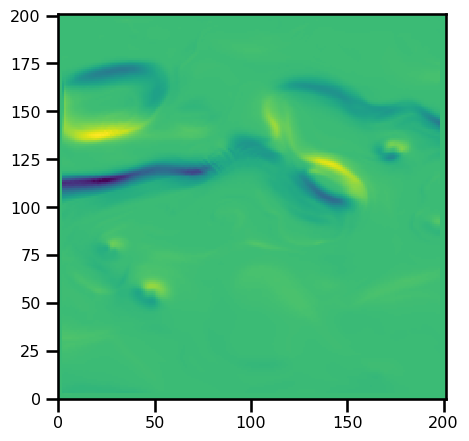

In [22]:
fig, ax = plt.subplots(figsize=(5,5))

ax.pcolormesh(-out)

plt.show()

## Altogther

In [23]:
def grid_variables(lon, lat):
    f0 = qg.coriolis_param(lat)
    dx, dy, f0 = qg.lat_lon_deltas(lon, lat)
    
    return dx, dy, f0

def streamfn_to_pv(psi, dx, dy, c: float=1.5):
    
    # Constants 
    # f0 = 1e-5 # Coriolis frequency
    # c1 = 2.7 # First baroclinic phase speed


    psi_lap = qg.laplacian_2d(psi, dx, dy)

    q = qg.streamfn_to_pvort(psi, dx, dy, c1)
    
    
    return q

def rhs_fn(q, psi, dx, dy):

    u, v = qg.streamfn_to_velocity(psi, dx, dy)

    u_plus, u_minus = qg.u_plusminus(u)

    v_plus, v_minus = qg.v_plusminus(v)

    dq_dx_f = qg.forward_diff_x(q, dx)
    dq_dy_f = qg.forward_diff_y(q, dy)
    dq_dx_b = qg.backward_diff_x(q, dx)
    dq_dy_b = qg.backward_diff_y(q, dy)

    t1 = u_plus * dq_dx_b + u_minus * dq_dx_f
    t2 = v_plus * dq_dy_b + v_minus * dq_dy_f
    t3 = qg.beta_cdiff(f0, dy) * qg.diff_y(v)

    out = t1 + t2 + t3

    out = out.at[:2,:].set(0.0)
    out = out.at[-3:,:].set(0.0)
    out = out.at[:,:2].set(0.0)
    out = out.at[:,-3:].set(0.0)
    
    return q, - out

In [24]:
dx, dy, f0 = grid_variables(lon, lat)

psi = qg.ssh_to_streamfn(ssh, f0)

q = qg.streamfn_to_pvort(psi, dx, dy)

q, rhs = rhs_fn(q, psi, lon, lat)

q_new = q + 600. * rhs # 600 seconds

### Elliptical Inversion

We have the following equation:

$$
(\nabla^2 - \frac{1}{L_R^2})\psi = q \\
$$

And we want to invert this so that we can find $\psi$ after knowing $q$. This is a linear solving problem

$$
\begin{aligned}
\mathbf{A}\psi &= q
\end{aligned}
$$

where $\mathbf{A} = \nabla^2 - \frac{1}{L_R^2}$



To solve this, we are going to use the conjugate gradient iteration.

$$
\mathbf{r}_0 = \mathbf{q} - A\boldsymbol{\psi}_0
$$

where:
* $\mathbf{r}_0\in\mathbb{R}^{N_x\times N_y}$
* $\mathbf{q}\in\mathbb{R}^{N_x\times N_y}$
* $\mathbf{A}\in\mathbb{R}^{N_x\times N_x}$
* $\boldsymbol{\psi}_0\in\mathbb{R}^{N_x\times N_y}$

If $\mathbf{r}_0$ is sufficiently small, then return $\boldsymbol{\psi}_0$ as the result. Otherwise, initialize the parameters

$$
\mathbf{p}_0 := \mathbf{r}_0 \\
k := 0
$$


```python
alpha_k = r*r
```

In [25]:
from jaxopt import linear_solve

def matvec_A(x):
    return qg.streamfn_to_pvort(x, dx, dy)

In [26]:
sol = linear_solve.solve_cg(matvec=matvec_A, b=q, init=q, tol=1e-15)
print(np.max(np.abs(sol - psi)))
sol = linear_solve.solve_gmres(matvec=matvec_A, b=q, tol=1e-15)
print(np.max(np.abs(sol - psi)))
sol = linear_solve.solve_bicgstab(matvec=matvec_A, b=q, init=q, tol=1e-15)
print(np.max(np.abs(sol - psi)))
sol = linear_solve.solve_normal_cg(matvec=matvec_A, b=q, init=q, tol=1e-15)
print(np.max(np.abs(sol - psi)))

2.473825588822365e-10
2.9103830456733704e-11
2.4374458007514477e-10
8.731149137020111e-11


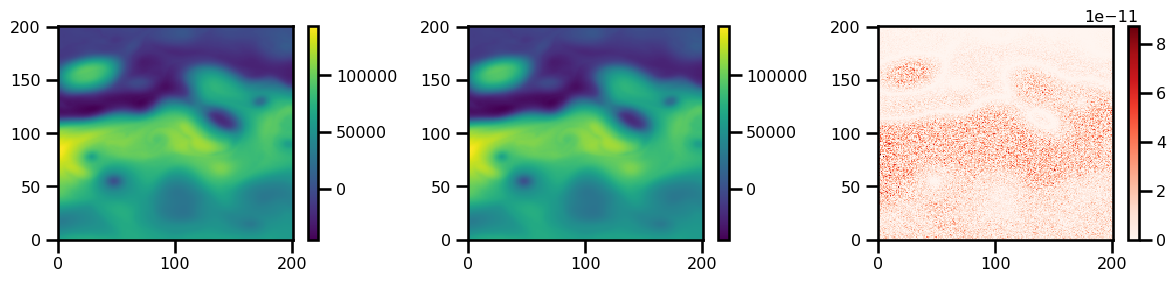

In [27]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3))
pts = ax[0].pcolormesh(psi)
plt.colorbar(pts)
pts = ax[1].pcolormesh(sol)
plt.colorbar(pts)
pts = ax[2].pcolormesh(np.abs(psi-sol), cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

```python
ssh_tensor,lon_input,lat_input = x
q = self.sshtoq((ssh_tensor,lon_input,lat_input))
q10 = self.dynqhardcoded((q,ssh_tensor,lon_input,lat_input))
hh = self.CGblockZERO((q10,ssh_tensor,lon_input,lat_input)) #, rn, dn
```



```python
## one iteration of the conjugate gradient
q_tensor, map_tensor, lon_input, lat_input = x
Fssh = self.sshtoq((map_tensor, lon_input, lat_input)) 
rr = q_tensor-Fssh
Frr = self.sshtoq((rr, lon_input, lat_input))
########## alpha
alpha = torch.sum(rr*rr, dim=(1,2,3), keepdim=True)/torch.sum(rr*Frr, dim=(1,2,3), keepdim=True)
##############
mapnext = map_tensor + alpha*rr
#rrnext = q_tensor - self.sshtoq((mapnext, lon_input, lat_input))
########## beta
#beta = torch.sum(rrnext*rrnext, dim=(1,2,3), keepdim=True)/torch.sum(rr*rr, dim=(1,2,3), keepdim=True)
##############
#dir1 = rrnext + beta*rr
return mapnext#, rrnext, dir1
```

In [49]:
from jaxopt.linear_solve import solve_cg
from jaxsw._src.models.qg_r import streamfn_to_pvort
from jaxsw._src.operators.functional.fd import difference

In [35]:
c1

1.5

## Looping

$$
\begin{aligned}
\psi^n &= f(\eta^n) \\
q^{n} &= f_2(\psi^n) \\
q^{n+1} &= q^{n} + \Delta t \hspace{1mm}\mathbf{rhs}(\psi, q) \\
\psi^{n+1} &= \text{Solve}(q^{n+1})
\end{aligned}
$$

In [36]:
24*60*3600,(60*10)

(5184000, 600)

In [90]:
from tqdm.autonotebook import trange

lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values

dx, dy, f0 = qg.lat_lon_deltas(lon, lat)
dt = 600 # 10 mins / 600 s
c1 = 1.5
way = 1
tol = 1e-15
n_iterations = 144
upwind = True

def step(ssh):
    
    # calculate stream function
    psi = qg.ssh_to_streamfn(ssh, f0)
    
    # calculate potential vorticity
    q = qg.streamfn_to_pvort_mine(psi, dx, dy, c1=c1)
    
    # calculate RHS
    rhs = qg.rhs_fn(q=q, psi=psi, dx=dx, dy=dy, f0=f0, way=way, upwind=upwind)
    
    # time step
    q = q + dt * rhs
    
    # calculate stream function
    psi = qg.pv_to_streamfn(q, dx, dy, tol=tol, c1=c1)
    
    # calculate ssh
    ssh = qg.streamfn_to_ssh(psi, f0)
    # print(ssh.min(), ssh.max())
    return ssh

step = jax.jit(step)


for iteration in trange(n_iterations):
    
    ssh = step(ssh)
    


  0%|          | 0/144 [00:00<?, ?it/s]

In [91]:
ssh.min(), ssh.max()

(Array(-0.37096846, dtype=float64), Array(1.16310116, dtype=float64))

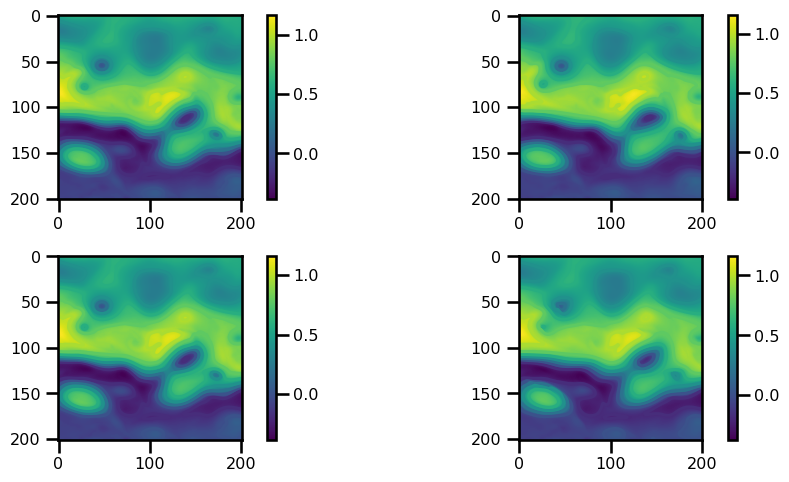

In [92]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5))

# 
ax[0,0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[0,0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[0,1].contour(ds.ssh[1].values, cmap="viridis")
pts = ax[0,1].imshow(ds.ssh[1].values, cmap="viridis")
plt.colorbar(pts)


ax[1,0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[1,0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[1,1].contour(ssh, cmap="viridis")
pts = ax[1,1].imshow(ssh, cmap="viridis")
plt.colorbar(pts)

plt.tight_layout()
plt.show()



In [85]:
from tqdm.autonotebook import trange

lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values

dx, dy, f0 = qg.lat_lon_deltas(lon, lat)
dt = 600 # 10 mins / 600 s
c1 = 1.5
way = 1
tol = 1e-15
n_iterations = 143 * 20
upwind = True



def step(ssh):
    
    # calculate stream function
    psi = qg.ssh_to_streamfn(ssh, f0)
    
    # calculate potential vorticity
    q = qg.streamfn_to_pvort_mine(psi, dx, dy, c1=c1)
    
    # calculate RHS
    rhs = qg.rhs_fn(q=q, psi=psi, dx=dx, dy=dy, f0=f0, way=way, upwind=upwind)
    
    # time step
    q = q + dt * rhs
    
    # calculate stream function
    psi = qg.pv_to_streamfn(q, dx, dy, tol=tol, c1=c1)
    
    # calculate ssh
    ssh = qg.streamfn_to_ssh(psi, f0)
    # print(ssh.min(), ssh.max())
    return ssh

step = jax.jit(step)


for iteration in trange(n_iterations):
    
    ssh = step(ssh)

  0%|          | 0/2860 [00:00<?, ?it/s]

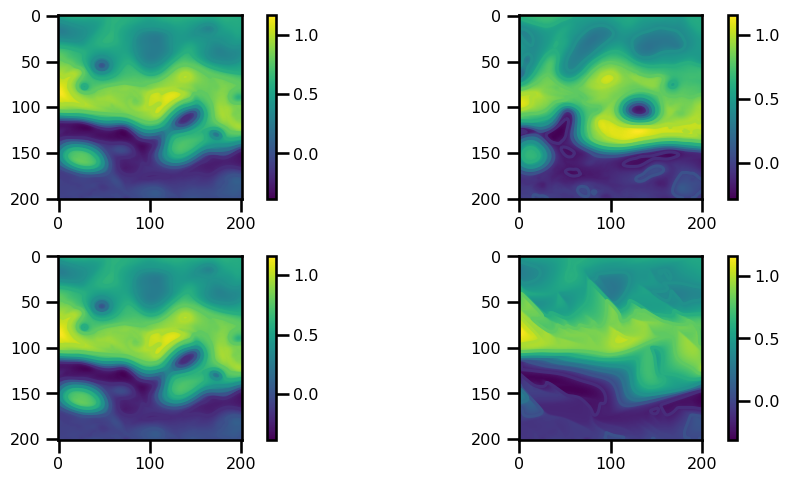

In [86]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5))

# 
ax[0,0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[0,0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[0,1].contour(ds.ssh[20].values, cmap="viridis")
pts = ax[0,1].imshow(ds.ssh[20].values, cmap="viridis")
plt.colorbar(pts)


ax[1,0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[1,0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[1,1].contour(ssh, cmap="viridis")
pts = ax[1,1].imshow(ssh, cmap="viridis")
plt.colorbar(pts)

plt.tight_layout()
plt.show()
